In [1]:
import pandas as pd
from access_onedrive import create_onedrive_directdownload
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [2]:
onedrive_link = 'https://1drv.ms/x/s!AsCp_kE1E5Md6U4PwNcWkXp_SnEL?e=3gStJc'
link = create_onedrive_directdownload(onedrive_link)
df = pd.read_excel(link)

In [3]:
df.head(5)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388797 entries, 0 to 388796
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       388797 non-null  int64 
 1   ER_No            388797 non-null  object
 2   Triage_Datetime  388797 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.9+ MB


In [4]:
#removing anomalies
df = df[df.Triage_Datetime != df.ER_No]
df.pop(df.columns[0])

0              0
1              1
2              2
3              3
4              4
           ...  
388792    388792
388793    388793
388794    388794
388795    388795
388796    388796
Name: Unnamed: 0, Length: 384095, dtype: int64

In [5]:
#fetching date from the datetime column
df['Triage_Datetime'] = pd.to_datetime(df['Triage_Datetime'])
df['Triage_Datetime'] = df['Triage_Datetime'].dt.date
df.head(5)

,ER_No,Triage_Datetime
0,E001467306,2019-04-30
1,E001461259,2019-04-19
2,E001453586,2019-04-05
3,E001455608,2019-04-09
4,E001467427,2019-04-30


In [6]:
new_df = df.groupby(['Triage_Datetime'])['Triage_Datetime'].count().reset_index(name='Count of Patients')
# new_df.index = new_df['Triage_Datetime']
# del new_df['Triage_Datetime']
new_df.head(5)
# new_df.info()


,Triage_Datetime,Count of Patients
0,2019-01-01,348
1,2019-01-02,371
2,2019-01-03,373
3,2019-01-04,361
4,2019-01-05,373


<Axes: xlabel='Triage_Datetime', ylabel='Count of Patients'>

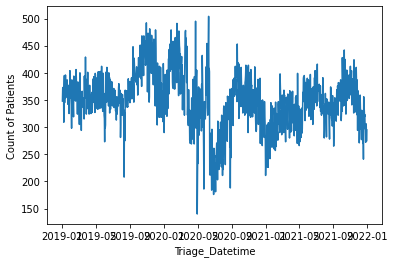

In [7]:
sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = new_df)

In [8]:

# x-label = date; y-label = count
new_df['Triage_Datetime'] = pd.to_datetime(new_df['Triage_Datetime'])
new_df.head()
new_df.info()
# train = new_df[new_df['Triage_Datetime'] < pd.to_datetime("2021-12", format='%Y-%m')]
# test = new_df[new_df['Triage_Datetime'] >= pd.to_datetime("2021-12", format='%Y-%m')] #keeping one month for testing
# train.head(5)
# train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Triage_Datetime    1096 non-null   datetime64[ns]
 1   Count of Patients  1096 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.2 KB


<AxesSubplot: xlabel='Triage_Datetime', ylabel='Count of Patients'>

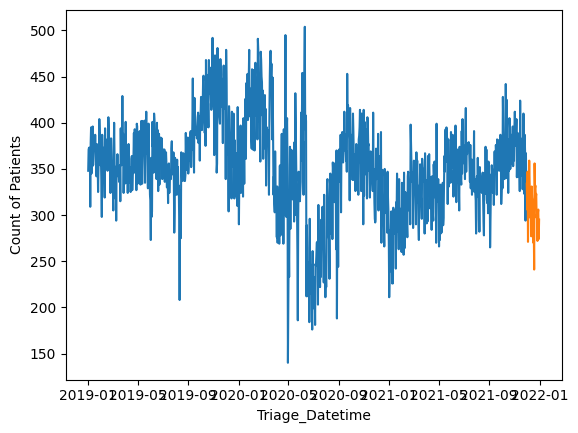

In [11]:
# sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = train)
# sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = test)

<h2> STATISTICAL TEST FOR STATIONARITY</h2>

In [9]:
st_df = new_df.copy()
st_df.index = st_df['Triage_Datetime']
del st_df['Triage_Datetime']
st_df.head()

,Count of Patients
Triage_Datetime,
2019-01-01,348
2019-01-02,371
2019-01-03,373
2019-01-04,361
2019-01-05,373


<h4> Summary Statistics </h4>

In [10]:
X = st_df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

#We split the dataset into two halves and checked their mean and variance. Since 
#they differ and the difference is statistically significant, the time series is likely non-stationary.

mean1=367.474453, mean2=333.428832
variance1=2879.953727, variance2=1892.934716


<h4> Augmented Dickey-Fuller Test </h4>

In [11]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(data):
    result = adfuller(data, autolag='AIC')
    # print(result)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    
#the p-value is greater than 0.05 hence we accept the null hypothesis 
#the ADF statistic value is also greater than all the critical values
#Hence, we conclude that the time series is non-stationary

ADF Statistic: -11.531944897658214
n_lags: 3.813072140025447e-21
p-value: 3.813072140025447e-21
Critial Values:
   1%, -3.4364476591811033
Critial Values:
   5%, -2.864232347211692
Critial Values:
   10%, -2.5682035004867494


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


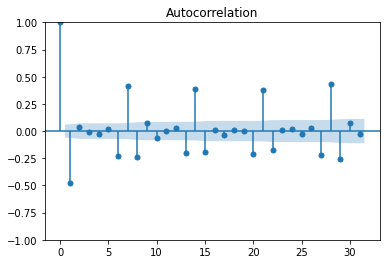

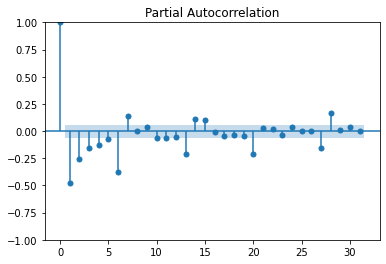

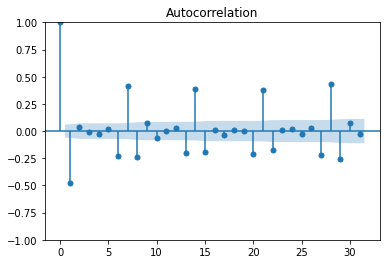

In [12]:
diff_df = pd.DataFrame()
diff_df['Count of Patients']= st_df['Count of Patients'].diff(periods=1)
diff_df.head()
diff_df = diff_df.dropna()
# st_df.head()
ADF_test(diff_df['Count of Patients'])

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# axes[1].set(ylim=(0,2))
plot_pacf(diff_df['Count of Patients']) #p = 3
plot_acf(diff_df['Count of Patients']) #q=2
# del st_df['Count of Patients d1']
# st_df.head()


<h2> TESTING FOR SEASONALITY </h4
>

In [14]:

from statsmodels.tsa.seasonal import seasonal_decompose
analysis = new_df.copy()
analysis.sort_index(inplace=True)
# analysis.index = analysis['Triage_Datetime']
# del analysis['Triage_Datetime']
analysis.head()
# new_df.set_index('Triage_Datetime', inplace=True)

# analysis = new_df[['Count of Patients']].copy()
# analysis.head()
decompose_result_mult = seasonal_decompose(x = analysis, model="additive")
seasonal = decompose_result_mult.seasonal
decompose_result_mult.plot()

TypeError: float() argument must be a string or a real number, not 'Timestamp'

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

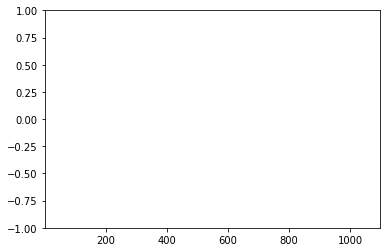

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(analysis)

<h2> TRAIN-TEST SPLIT </h2>

In [27]:
# st_df['Triage_Datetime'] = pd.to_datetime(new_df['Triage_Datetime'])
train = st_df[st_df.index < pd.to_datetime("2021-12", format='%Y-%m')]
test = st_df[st_df.index >= pd.to_datetime("2021-12", format='%Y-%m')] 
train.info()
train.head()
# test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1065 entries, 2019-01-01 to 2021-11-30
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Count of Patients  1065 non-null   int64
dtypes: int64(1)
memory usage: 16.6 KB


,Count of Patients
Triage_Datetime,
2019-01-01,348
2019-01-02,371
2019-01-03,373
2019-01-04,361
2019-01-05,373


<h2> MODELLING

In [28]:
import numpy as np
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape*100

<h4> AUTO ARIMA

In [29]:
# train.index = train['Triage_Datetime']
# del train['Triage_Datetime']
train.head()



,Count of Patients
Triage_Datetime,
2019-01-01,348
2019-01-02,371
2019-01-03,373
2019-01-04,361
2019-01-05,373


In [30]:
# test.index = test['Triage_Datetime']
# del test['Triage_Datetime']
test.head()

,Count of Patients
Triage_Datetime,
2021-12-01,334
2021-12-02,306
2021-12-03,347
2021-12-04,271
2021-12-05,307


In [256]:
# from pmdarima.arima import auto_arima
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10607.204, Time=2.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11034.470, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10761.838, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10609.967, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11032.470, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10603.198, Time=2.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10610.477, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10610.140, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10602.415, Time=1.99 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10607.317, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=10587.720, Time=2.56 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=10602.862, Time=1.59 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=10588.833, Time=3.24 sec
 ARIMA(1,1,5)(0,0,0)[0] i

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True)

In [232]:
from sklearn.metrics import mean_squared_error
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

arima_rmse = np.sqrt(mean_squared_error(test['Count of Patients'], forecast["Prediction"]))
print("RMSE: ",arima_rmse)
print("MAPE: ", mape(test, forecast["Prediction"]))

RMSE:  47.59613179413928
MAPE:  14.016076906622853


<AxesSubplot: xlabel='Triage_Datetime'>

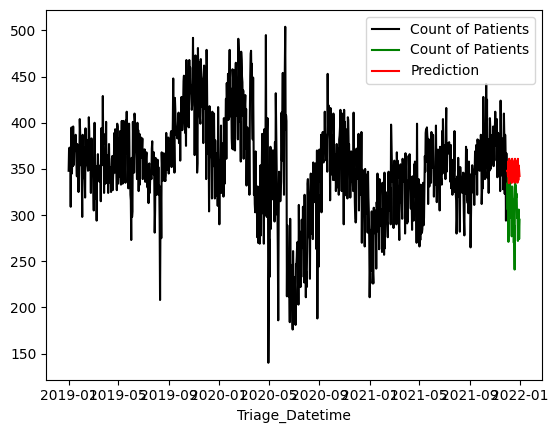

In [225]:
sns.lineplot(data = train, palette = ['black'])
sns.lineplot(data = test, palette = ['green'])
sns.lineplot(data = forecast, palette = ['red'])

<h4> ARIMA

In [106]:
from statsmodels.tsa.arima.model import ARIMA


In [295]:
y = train['Count of Patients']
ARIMAmodel = ARIMA(y, order = (3, 1, 2)) #p=3, d=1, q=2
ARIMAmodel = ARIMAmodel.fit()
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
# y_pred_out.head()

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Hp\AppData\Local\

Triage_Datetime
2021-12-01    345.896214
2021-12-02    350.290383
2021-12-03    344.546357
2021-12-04    354.461698
2021-12-05    347.025914
Name: Predictions, dtype: float64

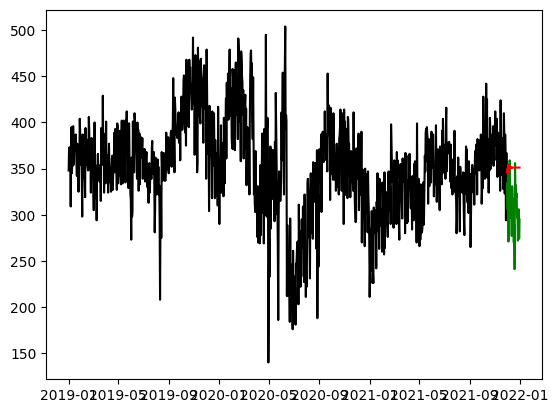

In [297]:
# np.cumsum(np.r_[y_pred_df["Predictions"][1],diff_y])
plt.plot(train, color='Black')
plt.plot(test, color='Green')
plt.plot(y_pred_out, color='Red', label = 'ARIMA Predictions')

In [298]:
#EVALUATION INDICATOR

from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test['Count of Patients'], y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)
print("MAPE: ", mape(test['Count of Patients'], y_pred_df["Predictions"]), '%')

RMSE:  50.28704277045543
MAPE:  14.86754546115806 %


<h4> SARIMA 

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# Seasonal ARIMA captures historical values, shock events and seasonality.
import statsmodels.api as sm
SARIMAXmodel = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 2), seasonal_order=(1, 1, 2, 12), enforce_stationarity = False)
SARIMAXmodel = SARIMAXmodel.fit()


y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA WITH BEST AIC VALUE

In [31]:
import statsmodels.api as sm
import itertools

y = train['Count of Patients']
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
#ARIMA(1, 1, 2)x(1, 1, 2, 12) gives AIC:10253.360110378233 (lowest)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:11594.521005306802


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:10823.650459869334


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:10700.687521452084
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:11193.915315213173


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:10825.282940275632


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:10698.81319706206


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:11039.728174287826


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:10713.646010299643


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:10699.48417639814
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:11240.72735568828


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:10400.803610178653


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:10285.022416560218


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:10820.412195418015


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:10402.049997335802


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:10283.041114324215


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:10607.33999948671


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:10304.914334529856


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:10284.906540323347
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:11218.100248745353


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:10391.361991082806


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:10275.568524407203


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:10815.101512546302


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:10392.702406180511


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:10273.744209147142


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:10609.327930858748


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:10305.877195813171


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:10275.66125485893
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:11429.413393256626


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:10560.061504772828


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:10435.786970501238


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:10952.924819510856


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:10555.804042200667


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:10433.963834472872


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:10742.028418698774


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:10436.60096048149


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:10435.790187575818


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:11205.573669110163


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:10401.123252838106


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:10285.68173730835


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:10803.515898915091


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10402.59766785525


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:10283.352849591789


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:10598.760259251474


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:10296.244118386216


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:10285.292736423242


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:11146.985426455074


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:10371.7123125339


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:10256.6736658786


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:10752.966388860583


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:10389.450189918447


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:10253.360110378233


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:10553.098261223717


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:10294.070312097085


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:10255.307842470063
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:11295.411750728448


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:10486.992050551866


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:10367.991743970935


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:10897.46196860209


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:10477.589510663784


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:10367.867543047601


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:10669.113457266478


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:10359.348786063347


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:10358.794975090506


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:11230.26228627735


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:10398.47663615756


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:10281.63884754135


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:10788.88683470494


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:10398.95347127123


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:10279.387301243796


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:10584.276650320677


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:10282.725113708504


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:10281.289432030177


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:11148.233070066057


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:10372.971061676832


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:10367.728256749117


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:10744.19391416544


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:10374.318443257507


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:10254.641358809151


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:10542.324584244308


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:10269.322897427903


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:10256.523036112721


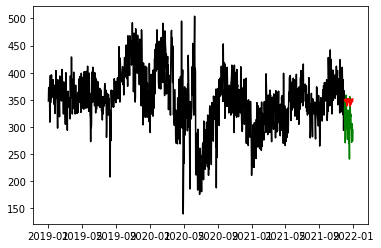

In [33]:
plt.plot(train, color='Black')
plt.plot(test, color='Green')
plt.plot(y_pred_out, color='Red', label = 'SARIMA Predictions')

In [35]:
from sklearn.metrics import mean_squared_error

sarima_rmse = np.sqrt(mean_squared_error(test['Count of Patients'], y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)
print("MAPE: ", mape(test['Count of Patients'], y_pred_df["Predictions"]), '%')

RMSE:  47.36792892927167
MAPE:  13.777026701042299 %


<h2> PREDICTING 

In [263]:
from datetime import timedelta 
print(new_df.index[-1])
print(new_df.index[-1]+timedelta(days=1))

2021-12-31 00:00:00
2022-01-01 00:00:00


In [264]:
# def interval(prediction_len):
#     pred_date = []
#     start_date = new_df.index[-1]+timedelta(days=1)
#     for i in range(prediction_len):
#         curr_date = start_date +timedelta(days=i)
#         pred_date.append(curr_date)

#     days = pd.DataFrame(pred_date)
#     return days
#     # print(test_df)

In [291]:
prediction_len = 7
y = new_df['Count of Patients']
ARIMAmodel = ARIMA(y, order = (2, 4, 4))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(steps = prediction_len)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
print(y_pred_df)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_out = y_pred_df["Predictions"] 

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


            lower Count of Patients  upper Count of Patients
2022-01-01               207.426829               356.670733
2022-01-02               199.990074               369.524352
2022-01-03               177.901614               382.290085
2022-01-04               164.838358               392.400703
2022-01-05               149.550540               401.702909
2022-01-06               136.150808               409.993916
2022-01-07               122.716504               417.862153


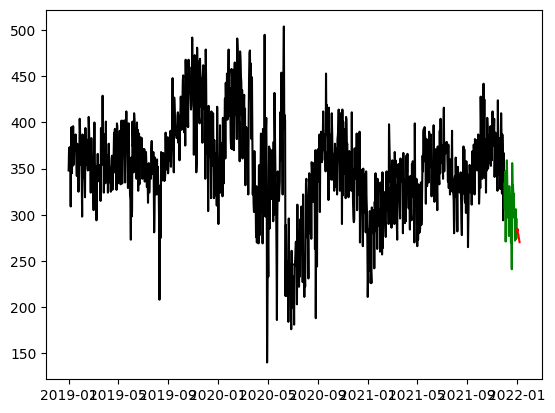

In [292]:
plt.plot(train, color='Black')
plt.plot(test, color='Green')
plt.plot(y_pred_out, color='Red', label = 'ARIMA Predictions')

<h3> FINAL FUNCTIONS FOR CALLING

In [293]:
def run_model(data):
    y = data['Count of Patients']
    ARIMAmodel = ARIMA(y, order = (2, 4, 4))
    ARIMAmodel = ARIMAmodel.fit()
    return ARIMAmodel

In [294]:
def get_predictions(data, prediction_len):
    ARIMAmodel = run_model(data)
    y_pred = ARIMAmodel.get_forecast(steps = prediction_len)
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_out = y_pred_df["Predictions"]
    return y_pred_out

In [304]:
def visualize(data, prediction_len):
    data.index = data['Triage_Datetime']
    del data['Triage_Datetime']
    plt.plot(data, color='Black')
    plt.plot(get_predictions(data, prediction_len), color='Red', label = 'ARIMA Predictions')
    

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


            lower Count of Patients  upper Count of Patients
2022-01-01               207.426829               356.670733
2022-01-02               199.990074               369.524352
2022-01-03               177.901614               382.290085
2022-01-04               164.838358               392.400703
2022-01-05               149.550540               401.702909
2022-01-06               136.150808               409.993916
2022-01-07               122.716504               417.862153
2022-01-08               109.627832               425.053741
2022-01-09                96.806021               432.085616
2022-01-10                83.901926               438.604700
2022-01-11                71.232743               445.117560
2022-01-12                58.314695               451.228025
2022-01-13                45.556735               457.431082
2022-01-14                32.457970               463.313270
2022-01-15                19.450954               469.358910
2022-01-16              

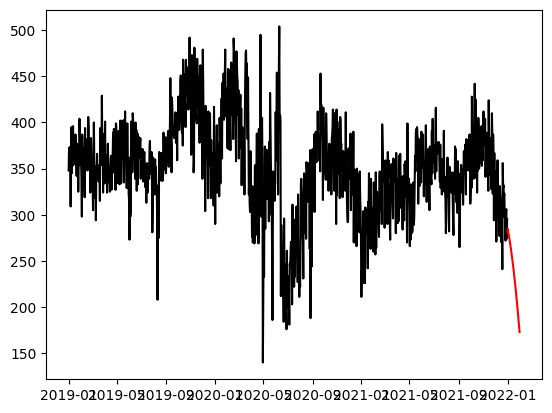

In [305]:
visualize(new_df, 31)